# Building 3 neural networks to classify spam messages

The goal is to build a classifier that can seperate spam messages (SMS) and ham messages, or non-spam.
The dataset is given at https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Text processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Deep learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D #CNN specific

from sklearn.manifold import TSNE # Visualizing word embedding

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
url = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/SMSSpamCollection"
messages = pd.read_csv(url, sep ='\t', names=["label", "message"])
messages = messages.drop_duplicates()

#Oversampled + Original copy of spam
url2 = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/BacktranslatedSpam"
new_spam = pd.read_csv(url2, sep ='\t', names=["message"]) # No label like the usual file here
spam_labels = ["spam" for i in range(len(new_spam))]
new_spam.insert(0, "label", spam_labels, allow_duplicates=True)

In [3]:
ham_msg = messages[messages.label =='ham']
print(len(ham_msg), len(new_spam))

4516 4571


In [4]:
new_spam_df = new_spam.sample(n = len(ham_msg), random_state = 754)
msg_df = pd.concat([ham_msg, new_spam_df])
msg_df.reset_index(drop=True)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,ham,Even my brother is not like to speak with me. ...
...,...,...
9027,spam,"<Redirected from 21870000>Hello, this is your..."
9028,spam,don't know you and you don't know me. Send CH...
9029,spam,"You can stop more club tones by answering ""ST..."
9030,spam,"Latest news! Police station toilet stolen, po..."


In [5]:
msg_labels = (msg_df['label'].map({'ham': 0, 'spam': 1})).values
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'],
                                                                  msg_labels,
                                                                  test_size=0.2,
                                                                  random_state=705)

In [6]:
#Tokenizer : turn words into integers
oov_tok = "<OOV>" # What to replace words that are not in the vocabulary with
vocab_size = 1000 # Maximum number of uniques words for tokenizer

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level=False, # Work words by word
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

# Discussion of hyper parameters of tokenizer
vocab_size equal to 500 means we drop 30% of the words in total (counting duplicates)

vocab_size equal to 1000 means we drop 20% of the words in total


When it comes to length of sentences, with a max_len of 50 we get more than 99.2% of the sentences, which makes it sufficiently long.

In [7]:
word_index = tokenizer.word_index
len(word_index)

8863

In [8]:
# Sequencing and padding on training and testing 
max_len = 50 # Max number of tokens, used with truncating and padding
trunc_type = "post" # Truncates sequences of tokens that are longer than max_len, post=right side
padding_type = "post" # Pads AFTER (with post) if sequence is shorter than max_len

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               padding = padding_type, truncating = trunc_type)

In [9]:
print(np.max(training_padded)) #We have 1000 words, INCLUDING the token 0 for padding and <OOV> for out of vocabulary
print(np.max(testing_padded))

999
999


In [10]:
print('Shape of training array: ', training_padded.shape)
print('Shape of testing array: ', testing_padded.shape)
print(type(training_padded))
print(type(train_labels))

Shape of training array:  (7225, 50)
Shape of testing array:  (1807, 50)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
#F1 score is not defined in Keras
#From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from tensorflow.keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Keras functions to define neural network
Embedding layer takes as input a vector of length *input_length* of **integers**, where the integers are between 0 and *vocab_size-1* (both bounds included). The output is a matrix of dimensions *input_length* * *output_dim*. In other words, each input neuron is projected into a space of dimension *output_dim*.

The flatten layer flattens the 2D output into a 1D array

Dense layer is another name for the regular fully connected layer.

In [21]:
#vocab_size = 1000
#max_len = 50
embedding_dim = 32
fc_size = 128
batch_size = 20
num_epochs = 5

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model.add(Flatten())
model.add(Dense(fc_size, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 237,057
Trainable params: 237,057
Non-trainable params: 0
_________________________________________________________________


In [22]:
hist = model.fit(training_padded, train_labels,
                    validation_data=(testing_padded, test_labels),
                    epochs=num_epochs, batch_size=batch_size)

Epoch 1/5
362/362 [==============================] - 2s 4ms/step - loss: 0.1544 - accuracy: 0.9390 - precision_m: 0.9448 - recall_m: 0.9251 - f1_m: 0.9284 - val_loss: 0.0454 - val_accuracy: 0.9845 - val_precision_m: 0.9936 - val_recall_m: 0.9779 - val_f1_m: 0.9848
Epoch 2/5
362/362 [==============================] - 1s 3ms/step - loss: 0.0239 - accuracy: 0.9940 - precision_m: 0.9958 - recall_m: 0.9919 - f1_m: 0.9934 - val_loss: 0.0268 - val_accuracy: 0.9900 - val_precision_m: 0.9898 - val_recall_m: 0.9903 - val_f1_m: 0.9896
Epoch 3/5
362/362 [==============================] - 1s 3ms/step - loss: 0.0063 - accuracy: 0.9990 - precision_m: 0.9998 - recall_m: 0.9980 - f1_m: 0.9989 - val_loss: 0.0230 - val_accuracy: 0.9923 - val_precision_m: 0.9956 - val_recall_m: 0.9895 - val_f1_m: 0.9922
Epoch 4/5
362/362 [==============================] - 1s 3ms/step - loss: 0.0030 - accuracy: 0.9996 - precision_m: 1.0000 - recall_m: 0.9993 - f1_m: 0.9996 - val_loss: 0.0258 - val_accuracy: 0.9923 - val_pr

In [23]:
loss, accuracy, precision, recall, f1_score = model.evaluate(testing_padded, test_labels, verbose=0)
print(accuracy, precision, recall, f1_score)

0.9916989207267761 0.9954739212989807 0.9883537888526917 0.9916729927062988


# Convolutional neural network

In [24]:
#vocab_size = 1000
#max_len = 50
#embedding_dim = 32
#batch_size = 20
#num_epochs = 5

    # CNN Architecture
conv1_kernel = 3
conv1_channel = 48 # Number of channels of output after 1st convolutional layer
maxPool1_size = 2
#fc_size = 128

In [25]:
CNN = Sequential()
CNN.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
# No flatten because Conv1D input is formatted this way
CNN.add(Conv1D(conv1_channel, conv1_kernel, activation='relu'))
CNN.add(MaxPooling1D(pool_size=maxPool1_size))
CNN.add(Flatten())
CNN.add(Dense(fc_size, activation='relu'))
CNN.add(Dense(1, activation='sigmoid'))
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
CNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 48)            4656      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 48)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               147584    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 184,369
Trainable params: 184,369
Non-trainable params: 0
________________________________________________

In [26]:
histCNN = CNN.fit(training_padded, train_labels,
                    validation_data=(testing_padded, test_labels),
                    epochs=num_epochs, batch_size=batch_size)

Epoch 1/5
362/362 [==============================] - 3s 4ms/step - loss: 0.1407 - accuracy: 0.9438 - precision_m: 0.9425 - recall_m: 0.9327 - f1_m: 0.9344 - val_loss: 0.0470 - val_accuracy: 0.9856 - val_precision_m: 0.9928 - val_recall_m: 0.9795 - val_f1_m: 0.9855
Epoch 2/5
362/362 [==============================] - 1s 4ms/step - loss: 0.0291 - accuracy: 0.9920 - precision_m: 0.9941 - recall_m: 0.9891 - f1_m: 0.9911 - val_loss: 0.0277 - val_accuracy: 0.9911 - val_precision_m: 0.9961 - val_recall_m: 0.9881 - val_f1_m: 0.9917
Epoch 3/5
362/362 [==============================] - 1s 4ms/step - loss: 0.0139 - accuracy: 0.9958 - precision_m: 0.9973 - recall_m: 0.9948 - f1_m: 0.9959 - val_loss: 0.0373 - val_accuracy: 0.9884 - val_precision_m: 0.9971 - val_recall_m: 0.9813 - val_f1_m: 0.9886
Epoch 4/5
362/362 [==============================] - 1s 3ms/step - loss: 0.0078 - accuracy: 0.9979 - precision_m: 0.9990 - recall_m: 0.9970 - f1_m: 0.9979 - val_loss: 0.0269 - val_accuracy: 0.9911 - val_pr

In [27]:
loss, accuracy, precision, recall, f1_score = CNN.evaluate(testing_padded, test_labels, verbose=0)
print(accuracy, precision, recall, f1_score)

0.9911455512046814 0.9862747192382812 0.995895504951477 0.9907557964324951


# Second convolutional network
- More convolutional layers
- More dense layers
- Dropout in the dense layers to reduce overfitting

In [29]:
#vocab_size = 1000
#max_len = 50
#embedding_dim = 32
#batch_size = 20
#num_epochs = 5

    # CNN2 Architecture
conv1_kernel = 3
conv1_channel = 48
maxPool1_size = 2
conv2_kernel = 3
conv2_channel = 64
maxPool2_size = 2
# Fully connected part
fc1_size = 128
dropout_rate1 = 0.2
fc2_size = 32
dropout_rate2 = 0.35

In [33]:
CNN2 = Sequential()
CNN2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
CNN2.add(Conv1D(conv1_channel, kernel_size=conv1_kernel, activation='relu'))
CNN2.add(MaxPooling1D(pool_size=maxPool1_size))
CNN2.add(Conv1D(conv2_channel, kernel_size=conv2_kernel, activation='relu'))
CNN2.add(MaxPooling1D(pool_size=maxPool2_size))
CNN2.add(Flatten())
CNN2.add(Dropout(dropout_rate1))
CNN2.add(Dense(fc1_size, activation='relu'))
CNN2.add(Dropout(dropout_rate2))
CNN2.add(Dense(fc2_size, activation='relu'))
CNN2.add(Dense(1, activation='sigmoid'))
CNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
CNN2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 48)            4656      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 24, 48)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 64)            9280      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 704)               0         
_________________________________________________________________
dropout (Dropout)            (None, 704)              

In [34]:
histCNN2 = CNN2.fit(training_padded, train_labels,
                    validation_data=(testing_padded, test_labels),
                    epochs=num_epochs, batch_size=batch_size)

Epoch 1/5
362/362 [==============================] - 3s 6ms/step - loss: 0.1638 - accuracy: 0.9325 - precision_m: 0.9296 - recall_m: 0.9138 - f1_m: 0.9161 - val_loss: 0.0557 - val_accuracy: 0.9834 - val_precision_m: 0.9935 - val_recall_m: 0.9763 - val_f1_m: 0.9841
Epoch 2/5
362/362 [==============================] - 2s 5ms/step - loss: 0.0393 - accuracy: 0.9885 - precision_m: 0.9900 - recall_m: 0.9878 - f1_m: 0.9882 - val_loss: 0.0335 - val_accuracy: 0.9911 - val_precision_m: 0.9961 - val_recall_m: 0.9870 - val_f1_m: 0.9911
Epoch 3/5
362/362 [==============================] - 2s 5ms/step - loss: 0.0219 - accuracy: 0.9927 - precision_m: 0.9904 - recall_m: 0.9899 - f1_m: 0.9897 - val_loss: 0.0297 - val_accuracy: 0.9900 - val_precision_m: 0.9905 - val_recall_m: 0.9922 - val_f1_m: 0.9910
Epoch 4/5
362/362 [==============================] - 2s 5ms/step - loss: 0.0114 - accuracy: 0.9961 - precision_m: 0.9967 - recall_m: 0.9952 - f1_m: 0.9957 - val_loss: 0.0530 - val_accuracy: 0.9862 - val_pr

In [35]:
loss, accuracy, precision, recall, f1_score = CNN2.evaluate(testing_padded, test_labels, verbose=0)
print(accuracy, precision, recall, f1_score)

0.9894853234291077 0.9850099086761475 0.9946423768997192 0.98952317237854


# Visualizing the word embedders
The most straightforward methods would be dimensional reduction methods, that project our 32-dimensional word embedding space into a 2-dimensional space we can visualize. The technique we'll use is tSNE.

In [36]:
embed_layer = CNN2.get_layer(CNN2.layers[0].name)
embedding = embed_layer.get_weights()
embedding = embedding[0] #Otherwise we have a list that contains an array

In [37]:
print(embedding.shape) #1000 words, including 0 token and token index number 1 for <OOV>

(1000, 32)


In [38]:
embeddingTSNE5 = TSNE(n_components=2, learning_rate='auto',
                     perplexity=5.0, init='random').fit_transform(embedding)
embeddingTSNE30 = TSNE(n_components=2, learning_rate='auto',
                     perplexity=30.0, init='random').fit_transform(embedding)

### Add colors for each word
Each word gets assigned a score in [0,1]. 0 corresponds to ham, 1 corresponds to spam.

How to compute the score :
- For each sentence, add to each word present in the sentence the prediction confidence of our model on the sentence.
- Average over all occurences of the word to rescale to [0,1]

In [39]:
#vocab_size = 1000
word_confidence = np.zeros((vocab_size, 2))

confidence_train = CNN2.predict(training_padded, batch_size=32)
L = training_padded.shape[0]
for i in range(L):
    for token in training_padded[i]:
        word_confidence[token, 0] += confidence_train[i]
        word_confidence[token, 1] += 1
            
confidence_test = CNN2.predict(testing_padded, batch_size=32)
L = testing_padded.shape[0]
for i in range(L):
    for token in testing_padded[i]:
        word_confidence[token, 0] += confidence_test[i]
        word_confidence[token, 1] += 1

In [40]:
word_color = np.zeros(vocab_size)
for i in range(vocab_size):
    if word_confidence[i, 1] == 0.0:
        print("Should never happen")
        word_color[i] = 0.5
    else:
        word_color[i] = word_confidence[i,0] / word_confidence[i,1]
print(word_color.shape)

(1000,)


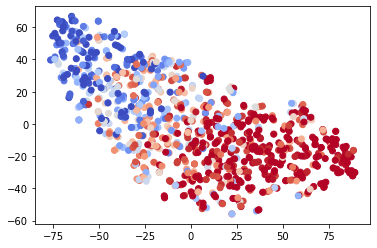

In [41]:
plt.scatter(embeddingTSNE5[:,0], embeddingTSNE5[:,1], c=word_color, cmap='coolwarm')
#coolwarm colormap : red = 1 (spam), blue = 0 (ham)
plt.show()

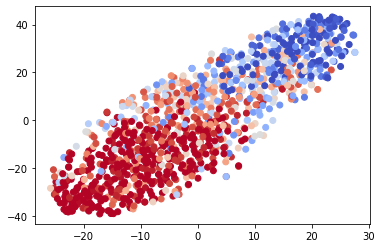

In [42]:
plt.scatter(embeddingTSNE30[:,0], embeddingTSNE30[:,1], c=word_color, cmap='coolwarm')
plt.show()

### Observations about tSNE plots and color
We can observe a clear division between the words most commonly associated with spam (deep red) and the ones associated with non-spam (blue) 

In [44]:
[w for w,v in word_index.items() if v < vocab_size and word_color[v] >= 0.9999] #Strongly associated with spam

['prize',
 'claim',
 '150p',
 'won',
 'landline',
 '18',
 '000',
 'guaranteed',
 'tone',
 '£1',
 'ringtone',
 'valid',
 'weekly',
 '150',
 'cs',
 '150ppm',
 'http',
 '500',
 '10p',
 '8007',
 'tones',
 'national',
 'mob',
 '750',
 'awarded',
 'sae',
 'collection',
 'bonus',
 'unsubscribe',
 'poly',
 '£1000',
 'entry',
 '08000930705',
 '800',
 '£500',
 '2003',
 'freemsg',
 '86688',
 'expires',
 'reward',
 'camcorder',
 'mobileupd8',
 '£2',
 'winner',
 '£2000',
 '08000839402',
 'ac',
 'ppm',
 'quiz',
 'operator',
 'suite342',
 '2lands',
 'ringtones',
 'rental',
 'charged',
 'standard',
 '03',
 'ipod',
 'wap',
 'unredeemed',
 '1000',
 '04',
 'txts',
 'dogging',
 '2004',
 'vouchers',
 'savamob',
 '00',
 '87066',
 'charity',
 '£3',
 'eg',
 "c's",
 "uk's",
 '0800',
 '£250',
 'specially',
 'call2optout',
 'awaits',
 'w1j6hl',
 '250',
 'pobox',
 '87077',
 "week's",
 '3030',
 'upgrade',
 'bluetooth',
 'maximize',
 'ldew',
 'logo',
 '08718720201',
 'hg',
 'credits',
 'custcare',
 '50p',
 'getzed'

# Word2Vec embedding
We'll use the gensim library for our implementation of word2Vec.

The format for the input text is a list of sentence, where a sentence is a list of strings (one string = one word)

The main parameters of word2Vec are :
- size (default 100) : Dimension of embedding space
- window (default 5) : Size of window for context
- min_count (default 5) : The minimum count of words to consider when training the model
- sg (default 0 or CBOW) : The training algorithm, either CBOW (0) (Continuous bag of words) or skip gram (1).

In [45]:
# Turning our data into a list of sentences
converted = tokenizer.sequences_to_texts(tokenizer.texts_to_sequences(train_msg))
print(len(converted))
print(type(converted[0].split()))
print(converted[7224].split()) # Number of words may be strictly less than 50

converted_test = tokenizer.sequences_to_texts(tokenizer.texts_to_sequences(test_msg))
print(len(converted_test))

7225
<class 'list'>
['but', 'your', 'not', 'here']
1807


In [46]:
sentences_train = [converted[i].split() for i in range(len(converted))]
sentences_test = [converted_test[i].split() for i in range(len(converted_test))]

In [47]:
#embedding_dim = 32
model = Word2Vec(sentences=sentences_train,
                 vector_size=embedding_dim,
                 window=5, min_count=1, workers=4)

word_vectors = model.wv
del model # word_vectors contains our dictionary and the embedding matrix.
          # We delete the model since we do not need to train it anymore.

In [48]:
print(len(word_vectors.key_to_index))
list(word_vectors.key_to_index.items())[:5]

999


[('<OOV>', 0), ('to', 1), ('you', 2), ('a', 3), ('the', 4)]

In [49]:
vocab = list(word_vectors.key_to_index)
word_matrix = word_vectors[vocab]
print(word_matrix.shape)

# Word2Vec embedding puts the token 0 for <OOV>, which means we need to add a line to our embedding matrix
# that corresponds to the filler token.
if word_matrix.shape[0] < vocab_size:
    word_matrix = np.vstack([np.zeros(embedding_dim), word_matrix])
    print(word_matrix.shape)

(999, 32)
(1000, 32)


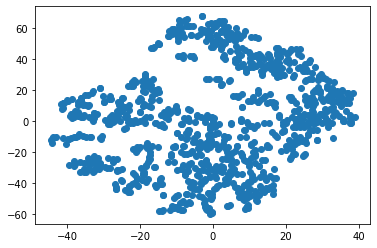

In [50]:
word_matrix_TSNE15 = TSNE(n_components=2, learning_rate='auto',
                     perplexity=15., init='random').fit_transform(word_matrix)

fix, ax = plt.subplots()
ax.scatter(word_matrix_TSNE15[:,0], word_matrix_TSNE15[:,1])

# Building a convolutional neural network using word2Vec
We will use the same architecture as our first convolutional neural network

In [52]:
#vocab_size = 1000
#max_len = 50
#embedding_dim = 32
#batch_size = 20
#num_epochs = 5

    # CNN Architecture
#conv1_kernel = 3
#conv1_channel = 48
#maxPool1_size = 2
#fc_size = 128

w2vCNN = Sequential()
w2vCNN.add(Embedding(vocab_size, embedding_dim, input_length=max_len,
                  weights=[word_matrix],
                   trainable=False))
w2vCNN.add(Conv1D(conv1_channel, conv1_kernel, activation='relu'))
w2vCNN.add(MaxPooling1D(pool_size=maxPool1_size))
w2vCNN.add(Flatten())
w2vCNN.add(Dense(fc_size, activation='relu'))
w2vCNN.add(Dense(1, activation='sigmoid'))
w2vCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
w2vCNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 48)            4656      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 48)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               147584    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 184,369
Trainable params: 152,369
Non-trainable params: 32,000
___________________________________________

In [53]:
histw2vCNN = w2vCNN.fit(training_padded, train_labels,
                    validation_data=(testing_padded, test_labels),
                    epochs=num_epochs, batch_size=batch_size)

Epoch 1/5
362/362 [==============================] - 2s 4ms/step - loss: 0.1470 - accuracy: 0.9466 - precision_m: 0.9618 - recall_m: 0.9335 - f1_m: 0.9436 - val_loss: 0.1016 - val_accuracy: 0.9568 - val_precision_m: 0.9866 - val_recall_m: 0.9313 - val_f1_m: 0.9554
Epoch 2/5
362/362 [==============================] - 1s 3ms/step - loss: 0.0795 - accuracy: 0.9722 - precision_m: 0.9795 - recall_m: 0.9642 - f1_m: 0.9704 - val_loss: 0.0846 - val_accuracy: 0.9668 - val_precision_m: 0.9895 - val_recall_m: 0.9486 - val_f1_m: 0.9665
Epoch 3/5
362/362 [==============================] - 1s 3ms/step - loss: 0.0572 - accuracy: 0.9801 - precision_m: 0.9839 - recall_m: 0.9754 - f1_m: 0.9784 - val_loss: 0.1150 - val_accuracy: 0.9590 - val_precision_m: 0.9956 - val_recall_m: 0.9257 - val_f1_m: 0.9568
Epoch 4/5
362/362 [==============================] - 1s 3ms/step - loss: 0.0373 - accuracy: 0.9877 - precision_m: 0.9918 - recall_m: 0.9843 - f1_m: 0.9874 - val_loss: 0.0825 - val_accuracy: 0.9751 - val_pr

In [54]:
loss, accuracy, precision, recall, f1_score = w2vCNN.evaluate(testing_padded, test_labels, verbose=0)
print(accuracy, precision, recall, f1_score)

0.9750968217849731 0.9838371872901917 0.9688553214073181 0.9754343628883362


# Visualizing the word embedder of word2Vec with colors

In [55]:
#vocab_size = 1000
word_confidence_w2v = np.zeros((vocab_size, 2))

confidence_train_w2v = w2vCNN.predict(training_padded, batch_size=32)
L = training_padded.shape[0]
for i in range(L):
    for token in training_padded[i]:
        word_confidence_w2v[token, 0] += confidence_train_w2v[i]
        word_confidence_w2v[token, 1] += 1
            
confidence_test_w2v = w2vCNN.predict(testing_padded, batch_size=32)
L = testing_padded.shape[0]
for i in range(L):
    for token in testing_padded[i]:
        word_confidence_w2v[token, 0] += confidence_test_w2v[i]
        word_confidence_w2v[token, 1] += 1

In [56]:
word_color_w2v = np.zeros(vocab_size)
for i in range(vocab_size):
    if word_confidence_w2v[i, 1] == 0.0:
        print("Should never happen")
        word_color_w2v[i] = 0.5
    else:
        word_color_w2v[i] = word_confidence_w2v[i,0] / word_confidence_w2v[i,1]
print(word_color_w2v.shape)

(1000,)


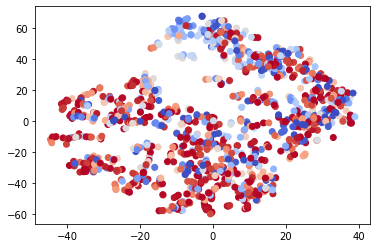

In [57]:
plt.scatter(word_matrix_TSNE15[:,0], word_matrix_TSNE15[:,1],
            c=word_color_w2v, cmap='coolwarm')
plt.show()

# Trying to trick model with my own messages

In [78]:
print(messages['message'][0])
print(type(messages['message'][0]))
print(type(messages))
print(type(messages['message']))

print(type(train_msg))
print(train_msg[0])
print(type(train_msg[0]))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
<class 'str'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
<class 'str'>


In [97]:
new_sentences = ["Are you free tonight ? I'd like to talk to you",
                'I honestly hate dating so much but my parents are pressuring me so much',
                'Dude do you also receive messages saying you won some amazing prize ?',
                "I could never spend £150 on a shirt bro",
                "Nobel Prizes are awarded in the fields of Physics, Chemistry, Physiology or Medicine, Literature, and Peace",
                "Congratulations ! You have won an amazing prize"]

In [98]:
new_sentences2 = pd.Series(new_sentences)

In [99]:
new_sequences = tokenizer.texts_to_sequences(new_sentences2)
print(new_sequences)
print("\n")
new_padded = pad_sequences (new_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)
print(new_padded[0])

[[27, 3, 13, 373, 1, 82, 2, 336, 2, 3], [6, 1, 1, 266, 44, 234, 59, 32, 1, 27, 1, 23, 44, 234], [1, 41, 3, 322, 127, 227, 1, 3, 73, 215, 953, 40], [6, 309, 571, 1, 943, 16, 4, 1, 1], [1, 1, 27, 224, 15, 5, 1, 17, 1, 1, 1, 18, 1, 1, 9, 1], [297, 3, 19, 73, 108, 953, 40]]


[ 27   3  13 373   1  82   2 336   2   3   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [100]:
new_predict = CNN2.predict(new_padded, batch_size=32)
print(new_predict)

[[9.54465210e-01]
 [1.41684711e-12]
 [1.00000000e+00]
 [3.20327341e-11]
 [1.47318915e-05]
 [1.00000000e+00]]


# Observations from these
It's surprisingly hard to trick the model into thinking it's spam

There's a LOT of common words the model simply doesn't have. As a result, it replaces those with the <OOV> token. I suspect that it's because the spelling found in SMS is not great and that the dataset dates from around 2006, when texting on phone wasn't a common practice to COMMUNICATE (therefore, most messages were about meeting at a place, ...)

# Testing our trained model on youtube messages

In [109]:
youtube_messages = pd.read_csv("C:/Users/thinh/DeepLearning/YoutubeSpamCollection/Youtube01-Psy.csv",
                               sep =',', names=["CommentID", "Author", "Date", "message", "label"])
youtube_messages = youtube_messages[1:] # First row is for the labels in the .csv files

In [110]:
youtube_messages['message']

1      Huh, anyway check out this you[tube] channel: ...
2      Hey guys check out my new channel and our firs...
3                 just for test I have to say murdev.com
4       me shaking my sexy ass on my channel enjoy ^_^ ﻿
5                watch?v=vtaRGgvGtWQ   Check this out .﻿
                             ...                        
346    How can this have 2 billion views when there's...
347           I don't now why I'm watching this in 2014﻿
348    subscribe to me for call of duty vids and give...
349    hi guys please my android photo editor downloa...
350    The first billion viewed this because they tho...
Name: message, Length: 350, dtype: object

In [111]:
youtube_sequences = tokenizer.texts_to_sequences(youtube_messages['message'])
youtube_padded = pad_sequences(youtube_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

In [112]:
youtube_padded[0]

array([  1, 798, 454,  57,  29,   3,   1,   1,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [113]:
youtube_predict = CNN2.predict(youtube_padded, batch_size=32)

In [153]:
youtube_predict2 = [round(youtube_predict[i].item()) for i in range(len(youtube_predict))]
youtube_labels = (youtube_messages['label'].map({'0': 0, '1': 1})).values

In [155]:
tn, fp, fn, tp = confusion_matrix(youtube_labels,
                                 youtube_predict2).ravel()

In [157]:
print(tn, fp, fn, tp) #Lots of false negatives : negative = model predicts 0 when it's actually spam

159 16 121 54


In [166]:
youtube_messages[['message', 'label']][150:160] #2 brackets

,message,label
151,Oppa! Yeah! Best Song!﻿,0
152,More... http://www.sunfrogshirts.com/Sunglass-...,1
153,https://www.facebook.com/teeLaLaLa﻿,1
154,http://www.twitch.tv/zxlightsoutxz﻿,1
155,reminds me of this song https://soundcloud.com...,1
156,What free gift cards? Go here http://www.swag...,1
157,"Search ""Chubbz Dinero - Ready Or Not "" Thanks ﻿",1
158,Follow me on Twitter @mscalifornia95﻿,1
159,😫😓😏😪😔😖😌😭😎😚😘😙😗😋😝😜😛😍😒😞😷😶😵😳😲😱😟😰😩😨😧😦😥😤😣😮😴😢😡😠😬😕😑😐😯😉...,0
160,▬▬▬▬▬▬▬▬▬▬ஜ۩۞۩ஜ▬▬▬▬▬▬▬▬ ＤＡＭＮ ＴＨＩＳ ＣＯＭＭＥＮＴ ＩＳ Ｆ...,0


# Trying to understand why it doesn't work great on youtube dataset
I would say :
- Lack of vocabulary (lots of words being projected onto <OOV> token)
- Lacks the detection of **youtube spam** features. Spam emails tend to be about how you "won" something and that you need to call a number, whereas spam on youtube seems to be about checking out someone's channel or clicking on a link